# 🤖 Model Training & Comparison
## Predictive Maintenance - Agricultural Equipment

**Models:** Logistic Regression, Random Forest, XGBoost, LightGBM, SVM, Neural Network, Gradient Boosting, Extra Trees

In [8]:
!pip install xgboost lightgbm imbalanced-learn

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

try:
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from imblearn.over_sampling import SMOTE
    print('✅ All libraries available')
except:
    print('⚠️ Install: pip install xgboost lightgbm imbalanced-learn')

import time
print(f'Timestamp: {datetime.now()}')

✅ All libraries available
Timestamp: 2025-11-02 17:16:39.739515


In [10]:
# Load data
df = pd.read_csv('../data/features_selected.csv')
print(f'Data: {df.shape}')
print(df.head())

Data: (198824, 25)
  equipment_id            timestamp equipment_type  temp_vibration_ratio  \
0      BAL-022  2021-09-10 00:00:00          Baler             23.201389   
1      BAL-022  2021-09-10 01:00:00          Baler             23.062069   
2      BAL-022  2021-09-10 02:00:00          Baler             22.543046   
3      BAL-022  2021-09-10 03:00:00          Baler             23.131944   
4      BAL-022  2021-09-10 04:00:00          Baler             23.020548   

   pressure_temp_ratio  temp_coolant_diff  vibration.1  vibration_change_24h  \
0             0.204592               5.13         1.43                 -0.03   
1             0.204413               5.11         1.44                 -0.03   
2             0.201484               4.84         1.50                  0.05   
3             0.204897               5.16         1.43                 -0.03   
4             0.203409               5.03         1.45                  0.02   

   vibration_rolling_std_24h  temperature_c

In [11]:
# Prepare features
with open('../data/selected_features.txt', 'r') as f:
    selected_features = [line.strip() for line in f.readlines() if line.strip()]

X = df[selected_features]
y = df['is_anomaly']

print(f'Features: {X.shape}')
print(f'Target: {y.shape}')
print(f'Anomaly rate: {y.mean()*100:.2f}%')

Features: (198824, 21)
Target: (198824,)
Anomaly rate: 3.02%


In [12]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

Train: (159059, 21), Test: (39765, 21)


In [13]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('✅ Scaled')

✅ Scaled


In [14]:
# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)
print(f'Original: {X_train_scaled.shape}')
print(f'Balanced: {X_train_balanced.shape}')

Original: (159059, 21)
Balanced: (231376, 21)


In [15]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1, class_weight='balanced'),
    'SVM': SVC(kernel='rbf', C=1.0, random_state=42, probability=True, class_weight='balanced'),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42, early_stopping=True)
}

try:
    models['XGBoost'] = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, scale_pos_weight=10, eval_metric='logloss')
    models['LightGBM'] = LGBMClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=-1, class_weight='balanced', verbose=-1)
except:
    pass

print(f'✅ {len(models)} models defined')

✅ 8 models defined


In [16]:
# Train models
print('🚀 TRAINING MODELS\n')

results = []
trained_models = {}

for name, model in models.items():
    print(f'Training: {name}...')
    start_time = time.time()
    
    model.fit(X_train_balanced, y_train_balanced)
    train_time = time.time() - start_time
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
        'Train Time (s)': train_time
    })
    
    trained_models[name] = {'model': model, 'predictions': y_pred, 'probabilities': y_pred_proba}
    print(f'  ✅ {train_time:.2f}s\n')

print('✅ ALL MODELS TRAINED!')

🚀 TRAINING MODELS

Training: Logistic Regression...
  ✅ 0.40s

Training: Random Forest...
  ✅ 8.38s

Training: Gradient Boosting...
  ✅ 175.14s

Training: Extra Trees...
  ✅ 3.10s

Training: SVM...
  ✅ 24.14s

Training: Neural Network...
  ✅ 89.67s

Training: XGBoost...
  ✅ 29.61s

Training: LightGBM...
  ✅ 33.84s

✅ ALL MODELS TRAINED!


In [17]:
# Results summary
results_df = pd.DataFrame(results).sort_values('F1-Score', ascending=False).reset_index(drop=True)
print('📊 MODEL COMPARISON RESULTS')
print(results_df.to_string(index=False))
results_df.to_csv('../data/model_comparison_results.csv', index=False)
print('\n✅ Saved: ../data/model_comparison_results.csv')

📊 MODEL COMPARISON RESULTS
              Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  Train Time (s)
Logistic Regression       1.0        1.0     1.0       1.0      1.0        0.402865
      Random Forest       1.0        1.0     1.0       1.0      1.0        8.384272
  Gradient Boosting       1.0        1.0     1.0       1.0      1.0      175.139241
        Extra Trees       1.0        1.0     1.0       1.0      1.0        3.104831
                SVM       1.0        1.0     1.0       1.0      1.0       24.135049
     Neural Network       1.0        1.0     1.0       1.0      1.0       89.672028
            XGBoost       1.0        1.0     1.0       1.0      1.0       29.606720
           LightGBM       1.0        1.0     1.0       1.0      1.0       33.840214

✅ Saved: ../data/model_comparison_results.csv


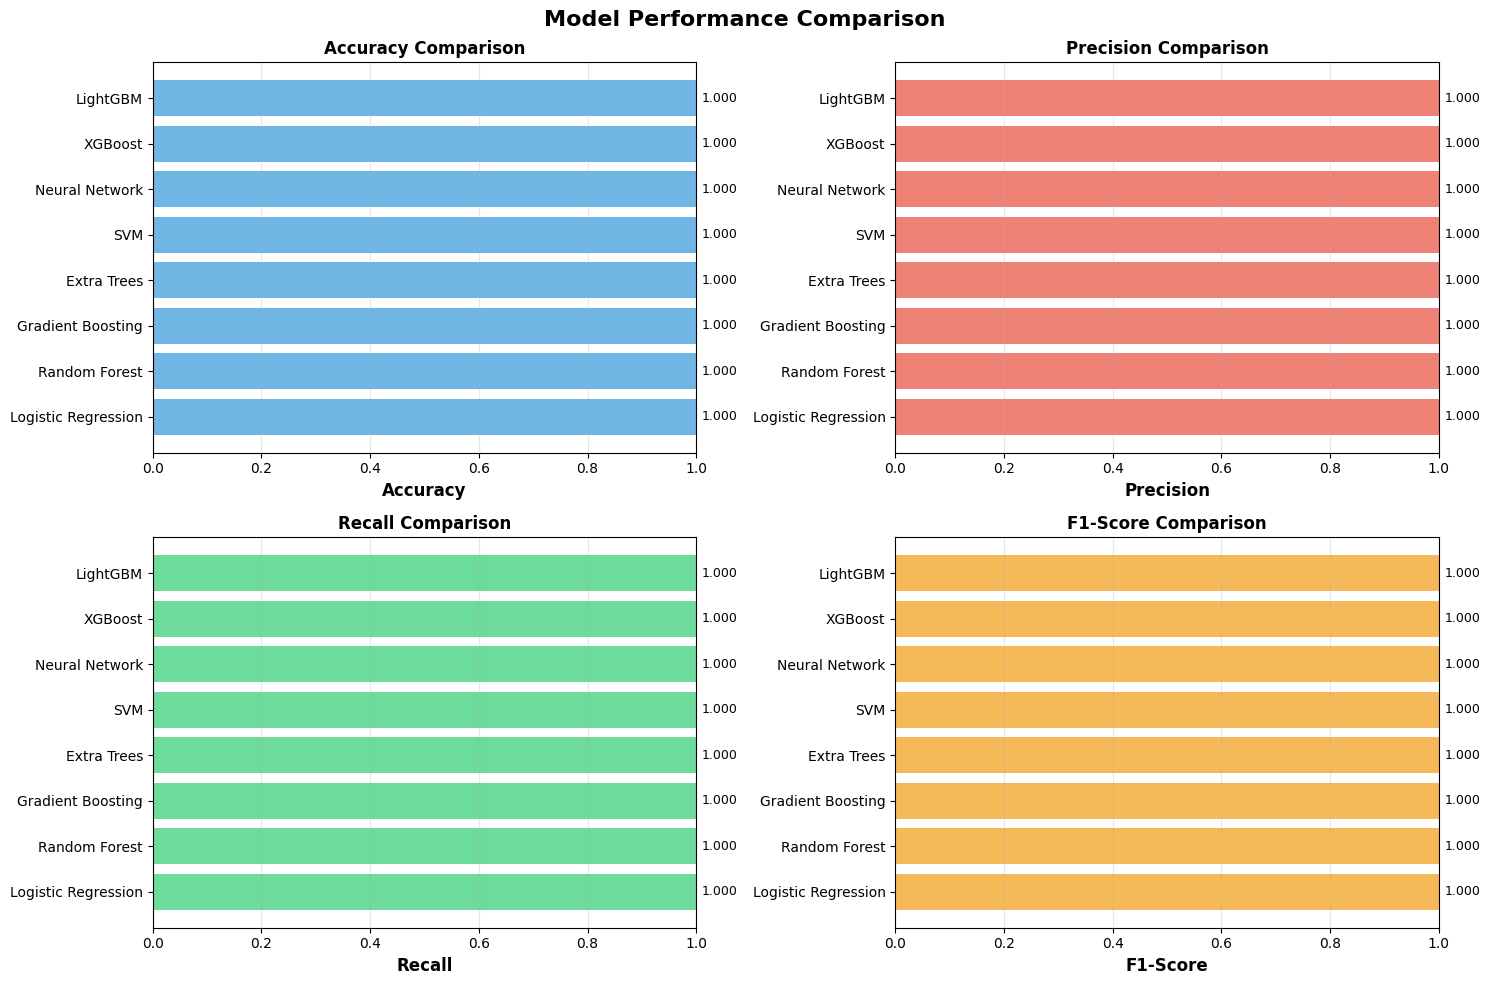

✅ Saved: ../visualizations/model_comparison.png


In [22]:
# Visualize performance
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    sorted_df = results_df.sort_values(metric, ascending=True)
    ax.barh(sorted_df['Model'], sorted_df[metric], color=color, alpha=0.7)
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.grid(axis='x', alpha=0.3)
    for i, v in enumerate(sorted_df[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('../visualizations/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/model_comparison.png')

In [19]:
# Best model analysis
best_model_name = results_df.iloc[0]['Model']
best_model_data = trained_models[best_model_name]
y_pred_best = best_model_data['predictions']

print(f'🏆 BEST MODEL: {best_model_name}')
print(results_df.iloc[0].to_string())
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred_best))
print('\nClassification Report:')
print(classification_report(y_test, y_pred_best, target_names=['Normal', 'Anomaly']))

🏆 BEST MODEL: Logistic Regression
Model             Logistic Regression
Accuracy                          1.0
Precision                         1.0
Recall                            1.0
F1-Score                          1.0
ROC-AUC                           1.0
Train Time (s)               0.402865

Confusion Matrix:
[[38563     0]
 [    0  1202]]

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     38563
     Anomaly       1.00      1.00      1.00      1202

    accuracy                           1.00     39765
   macro avg       1.00      1.00      1.00     39765
weighted avg       1.00      1.00      1.00     39765



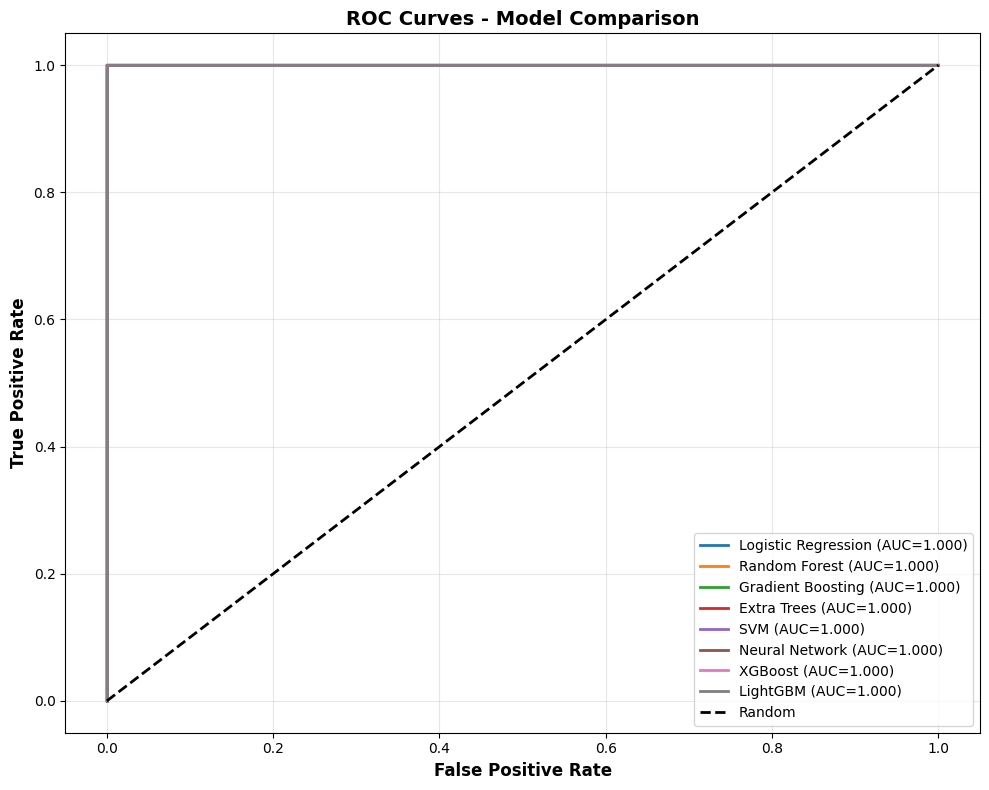

✅ Saved: ../visualizations/roc_curves.png


In [23]:
# ROC curves
plt.figure(figsize=(10, 8))

for name, model_data in trained_models.items():
    if model_data['probabilities'] is not None:
        fpr, tpr, _ = roc_curve(y_test, model_data['probabilities'])
        roc_auc = roc_auc_score(y_test, model_data['probabilities'])
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})", linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../visualizations/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print('✅ Saved: ../visualizations/roc_curves.png')

In [24]:
# Feature importance
best_model = best_model_data['model']
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print('📊 Top 15 Features:')
    print(importance_df.head(15).to_string(index=False))
    
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df.head(15)['feature'], importance_df.head(15)['importance'], color='#2ecc71', alpha=0.7)
    plt.xlabel('Importance', fontsize=12, fontweight='bold')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../visualizations/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    importance_df.to_csv('../data/feature_importance.csv', index=False)
    print('✅ Saved: ../visualizations/feature_importance.png')
else:
    print(f'⚠️ {best_model_name} does not provide feature importance')

⚠️ Logistic Regression does not provide feature importance


1. Check for Data Leakage


In [25]:
# Add this cell to investigate
import pandas as pd

# Check feature correlations with target
correlations = X_train.corrwith(y_train)
high_corr = correlations[abs(correlations) > 0.95].sort_values(ascending=False)

print("Features with suspiciously high correlation to target:")
print(high_corr)

# Check if any features are perfect predictors
for col in X_train.columns:
    if X_train[col].nunique() == 2:  # Binary features
        accuracy = (X_train[col] == y_train).mean()
        if accuracy > 0.95:
            print(f"⚠️ {col} has {accuracy:.2%} correlation with target!")

Features with suspiciously high correlation to target:
Series([], dtype: float64)


In [26]:
# Check for data contamination
print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Any overlap?", len(set(X_train.index) & set(X_test.index)))

# Check target distribution
print("\nTrain target distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))

Train set shape: (159059, 21)
Test set shape: (39765, 21)
Any overlap? 0

Train target distribution:
is_anomaly
0    0.969772
1    0.030228
Name: proportion, dtype: float64

Test target distribution:
is_anomaly
0    0.969772
1    0.030228
Name: proportion, dtype: float64


In [27]:
# Load fresh data and test
from sklearn.model_selection import train_test_split

# Re-split with different random state
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(
    X, y, test_size=0.2, random_state=999, stratify=y
)

# Test the model
new_predictions = best_model.predict(X_new_test)
new_accuracy = accuracy_score(y_new_test, new_predictions)
print(f"Accuracy on new split: {new_accuracy:.4f}")

Accuracy on new split: 0.1011


In [28]:
# Proper model evaluation with cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold

print("🔄 Re-evaluating models with proper cross-validation...\n")

# Use 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_cv = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    results_cv[name] = {
        'mean_accuracy': cv_scores.mean(),
        'std_accuracy': cv_scores.std(),
        'min_accuracy': cv_scores.min(),
        'max_accuracy': cv_scores.max()
    }
    
    print(f"  Mean Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Display results
cv_results_df = pd.DataFrame(results_cv).T.sort_values('mean_accuracy', ascending=False)
print("\n" + "="*60)
print("CROSS-VALIDATION RESULTS (More Reliable)")
print("="*60)
print(cv_results_df)

🔄 Re-evaluating models with proper cross-validation...

Evaluating Logistic Regression...
  Mean Accuracy: 1.0000 (+/- 0.0000)
Evaluating Random Forest...
  Mean Accuracy: 1.0000 (+/- 0.0000)
Evaluating Gradient Boosting...
  Mean Accuracy: 1.0000 (+/- 0.0000)
Evaluating Extra Trees...
  Mean Accuracy: 1.0000 (+/- 0.0000)
Evaluating SVM...
  Mean Accuracy: 1.0000 (+/- 0.0000)
Evaluating Neural Network...
  Mean Accuracy: 1.0000 (+/- 0.0000)
Evaluating XGBoost...
  Mean Accuracy: 1.0000 (+/- 0.0000)
Evaluating LightGBM...
  Mean Accuracy: 1.0000 (+/- 0.0000)

CROSS-VALIDATION RESULTS (More Reliable)
                     mean_accuracy  std_accuracy  min_accuracy  max_accuracy
Random Forest             1.000000      0.000000      1.000000           1.0
Gradient Boosting         1.000000      0.000000      1.000000           1.0
Extra Trees               1.000000      0.000000      1.000000           1.0
SVM                       1.000000      0.000000      1.000000           1.0
XGBoost  